# **Part 1: Data Analysis**

## 1. Data Exploration & Cleansing 

**(a) Are there any data quality issues in the dataset? What steps would you take to clean or refine the data?**

*The dataset in `.txt` format, which can be addressed by loading the file with proper delimiters using `pandas.read_csv()`. Duplicate rows exist, so we can detect them with `df.duplicated()` and drop them with `df.drop_duplicates()`. Missing values in columns like `chn`, `cus_no`, `gndr`, and `age` occur due to incomplete records. To handle this, we can fill missing values `cus_no`,`gndr`, and `age` using a mapping from `acc_no` (since they are related), fill missing `chn` values based on transaction types (e.g., filling 'IB' for `trn_desc` values like 'IBK', 'FUND TRANSFER' and 'SALARY'). By applying these refinements, we can clean the dataset for analysis.*

**(b) What are the key characteristics of the dataset? Summarise the distribution of transactions, key statistics, and any anomalies you notice?**

*The dataset consists of 20,639 transactions with key columns including `trn_no`, `acc_no`, `cus_no`, `brn_cd`, `trn_type`, `trn_dt`, `trn_time`, `amt`, `trn_desc`, `chn`, `gndr` and `age`. The `trn_desc` column shows that the majority of transactions are labeled as "FUND TRANSFER" (15,145 occurrences), followed by "PAYMENT" (3,835) and smaller numbers for other transaction types. Gender distribution reveals a predominance of male (13,335) over female (7,301) participants. In terms of channels, "IB" is the most common (16,982), with smaller occurrences of other channels like "MEPS" (1,189) and "POS" (1,113). The transaction amount (`amt`) ranges from 0.1 to 10,000, with a mean of 857.54 and a high standard deviation of 1,635.89, indicating significant variability. The age of customers ranges from 25 to 73, with a mean of 51.49 years. Missing values are present in the `cus_no`, `chn`, `gndr`, and `age` columns, with `chn` having the most significant missing data (419 nulls). There are also some duplicates in the dataset, particularly in customer-related fields, which need to be addressed to ensure accurate analysis. The dataset will benefit from handling the missing values and duplicates before further analysis.*

In [128]:
#import libraries
import pandas as pd
import csv
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [129]:
#Load the TXT data into a pandas DataFrame
df = pd.read_csv("dummy dataset.txt", delimiter='|')
df.sample(5)

,trn_no,acc_no,cus_no,brn_cd,trn_type,trn_dt,trn_time,amt,trn_desc,chn,gndr,age
13854,69223199793248508794,268674498118,4.732104e+09,631233,DEBIT,2023-06-05T00:00:00.000Z,165228,199.65,SALE DEBIT,POS,FEMALE,46.0
18847,6865244104675943890,709400571680,4.071105e+09,678972,DEBIT,2023-08-20T00:00:00.000Z,181110,91.20,PAYMENT,MEPS,MALE,58.0
11882,991046577630934219,715449380839,5.966480e+09,339201,DEBIT,2023-08-04T00:00:00.000Z,121429,900.00,FUND TRANSFER,IB,MALE,64.0
16593,43615083742399744681,695805725787,4.113495e+09,631233,DEBIT,2023-06-20T00:00:00.000Z,125424,90.00,SALE DEBIT,POS,MALE,43.0
8638,74054880541671838682,568575048767,5.580577e+09,339201,DEBIT,2023-06-03T00:00:00.000Z,230756,50.00,FUND TRANSFER,IB,FEMALE,65.0


In [130]:
# drop all duplicated rows
df.drop_duplicates(inplace=True)

In [131]:
# Check for Missing Values
df.isnull().sum()

trn_no        0
acc_no        0
cus_no        2
brn_cd        0
trn_type      0
trn_dt        0
trn_time      0
amt           0
trn_desc      0
chn         419
gndr          3
age           2
dtype: int64

In [132]:
# nunique value in columns
df.nunique()

trn_no      15656
acc_no         94
cus_no         94
brn_cd         25
trn_type        2
trn_dt         92
trn_time    13716
amt          3758
trn_desc        6
chn             5
gndr            2
age            32
dtype: int64

In [133]:
# Check rows where 'chn' is null and group by 'trn_desc'
df[df['chn'].isnull()].groupby('trn_desc').size()

trn_desc
FUND TRANSFER     82
IBK              146
SALARY           191
dtype: int64

In [134]:
# Group by 'trn_desc' and count unique 'chn' values for each group
df[df['trn_desc'].isin(['SALARY', 'IBK', 'FUND TRANSFER'])].groupby('trn_desc')['chn'].nunique()

trn_desc
FUND TRANSFER    1
IBK              0
SALARY           0
Name: chn, dtype: int64

In [135]:
# Filter the rows where 'trn_desc' is 'FUND TRANSFER' with column 'chn' 
values = df[df['trn_desc'] == 'FUND TRANSFER']
values[['chn']]

,chn
1,IB
3,IB
4,IB
6,IB
7,IB
...,...
20324,NaN
20382,NaN
20405,NaN
20411,NaN


In [136]:
# Check the number of unique values for 'acc_no', 'cus_no', 'age', and 'gndr' for a specific account number.
df[df['acc_no'] == 135566817347][['acc_no', 'cus_no', 'age', 'gndr']].nunique()

acc_no    1
cus_no    1
age       1
gndr      1
dtype: int64

In [137]:
# Create mappings from acc_no to cus_no, age, and gndr
acc_to_cus = df.dropna(subset=['acc_no', 'cus_no']).set_index('acc_no')['cus_no'].to_dict()
acc_to_age = df.dropna(subset=['acc_no', 'age']).set_index('acc_no')['age'].to_dict()
acc_to_gndr = df.dropna(subset=['acc_no', 'gndr']).set_index('acc_no')['gndr'].to_dict()

# Fill missing values using the mappings
df['cus_no'] = df['cus_no'].fillna(df['acc_no'].map(acc_to_cus))
df['age'] = df['age'].fillna(df['acc_no'].map(acc_to_age))
df['gndr'] = df['gndr'].fillna(df['acc_no'].map(acc_to_gndr))

In [138]:
# Assuming that 'trn_desc' value of SALARY, FUND TRANSFER, IBK are using 'IB' for 'chn'. 
df['chn'].fillna('IB', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_12540\3079129497.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['chn'].fillna('IB', inplace=True)


In [139]:
# # Save the updated dataframe to a new CSV file
# df.to_csv("new dummy dataset.txt", index=False)

In [140]:
# # Read the CSV file into a Pandas dataframe
# df = pd.read_csv("new dummy dataset.txt")

In [141]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15661 entries, 0 to 20636
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   trn_no    15661 non-null  object 
 1   acc_no    15661 non-null  int64  
 2   cus_no    15661 non-null  float64
 3   brn_cd    15661 non-null  int64  
 4   trn_type  15661 non-null  object 
 5   trn_dt    15661 non-null  object 
 6   trn_time  15661 non-null  int64  
 7   amt       15661 non-null  float64
 8   trn_desc  15661 non-null  object 
 9   chn       15661 non-null  object 
 10  gndr      15661 non-null  object 
 11  age       15661 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 1.6+ MB


In [142]:
#conversion of data type 
df['trn_dt'] = pd.to_datetime(df['trn_dt']) # Converts to date format
df['trn_time'] = pd.to_datetime(df['trn_time'], format='%H%M%S') # Converts to time format
df['acc_no'] = df['acc_no'].astype(str) # Converts to string format
df['cus_no'] = df['cus_no'].astype(str) # Converts to string format
df['trn_type'] = df['trn_type'].astype('category') # Converts to string catrgory
df['trn_desc'] = df['trn_desc'].astype('category') # Converts to string catrgory
df['chn'] = df['chn'].astype('category') # Converts to string catrgory
df['gndr'] = df['gndr'].astype('category') # Converts to string catrgory

In [143]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15661 entries, 0 to 20636
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   trn_no    15661 non-null  object             
 1   acc_no    15661 non-null  object             
 2   cus_no    15661 non-null  object             
 3   brn_cd    15661 non-null  int64              
 4   trn_type  15661 non-null  category           
 5   trn_dt    15661 non-null  datetime64[ns, UTC]
 6   trn_time  15661 non-null  datetime64[ns]     
 7   amt       15661 non-null  float64            
 8   trn_desc  15661 non-null  category           
 9   chn       15661 non-null  category           
 10  gndr      15661 non-null  category           
 11  age       15661 non-null  float64            
dtypes: category(4), datetime64[ns, UTC](1), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.1+ MB


In [144]:
df.sample(5)

,trn_no,acc_no,cus_no,brn_cd,trn_type,trn_dt,trn_time,amt,trn_desc,chn,gndr,age
2023,24957879366195421123,584302038586,5570333082.0,339201,DEBIT,2023-06-25 00:00:00+00:00,1900-01-01 16:24:22,770.63,FUND TRANSFER,IB,MALE,45.0
13481,12744259535914491199,268674498118,4732103968.0,678972,DEBIT,2023-08-31 00:00:00+00:00,1900-01-01 20:29:18,31.40,PAYMENT,MEPS,FEMALE,46.0
12450,58322849806473610288,530374001406,2854104473.0,728812,DEBIT,2023-06-29 00:00:00+00:00,1900-01-01 18:27:25,100.00,PAYMENT,FPX,MALE,52.0
11402,95289928225792345890,976461201839,2456185095.0,339201,DEBIT,2023-07-07 00:00:00+00:00,1900-01-01 15:04:26,5600.00,FUND TRANSFER,IB,FEMALE,46.0
5295,49233636676156183387,492064485044,8420219386.0,449836,DEBIT,2023-06-23 00:00:00+00:00,1900-01-01 11:37:21,4000.00,FUND TRANSFER,IB,FEMALE,54.0


In [145]:
# description of dataset
df.describe().T

,count,mean,min,25%,50%,75%,max,std
brn_cd,15661.0,453588.971075,143953.0,339201.0,449836.0,449836.0,732189.0,121581.06303
trn_time,15661,1900-01-01 14:48:34.599706368,1900-01-01 03:22:49,1900-01-01 11:00:15,1900-01-01 14:44:57,1900-01-01 18:52:29,1900-01-01 23:57:42,NaN
amt,15661.0,841.689762,0.1,65.9,200.0,780.0,10000.0,1639.027949
age,15661.0,51.448503,25.0,46.0,52.0,57.0,73.0,8.169703


In [146]:
# Display the unique values in the 'trn_desc' column
df['trn_desc'].value_counts()

trn_desc
FUND TRANSFER    10654
PAYMENT           3348
SALE DEBIT        1113
CDEP               209
SALARY             191
IBK                146
Name: count, dtype: int64

In [147]:
# Display the unique values in the 'gndr' column
df['gndr'].value_counts()

gndr
MALE      10197
FEMALE     5464
Name: count, dtype: int64

In [148]:
# Display the unique values in the 'chn' column
df['chn'].value_counts()

chn
IB             12423
MEPS            1189
POS             1113
FPX              727
BRNCH / ATM      209
Name: count, dtype: int64

In [149]:
# Display the unique values in the 'amt' column
df['amt'].describe()

count    15661.000000
mean       841.689762
std       1639.027949
min          0.100000
25%         65.900000
50%        200.000000
75%        780.000000
max      10000.000000
Name: amt, dtype: float64

In [150]:
# Display the unique values in the 'age' column
df['age'].describe()

count    15661.000000
mean        51.448503
std          8.169703
min         25.000000
25%         46.000000
50%         52.000000
75%         57.000000
max         73.000000
Name: age, dtype: float64

## 2. Transaction Volume & Trends

**(a) What is the average transaction amount? How many transactions do customers make per month on average?**

*Average Transaction Amount: 841.69*

*Average Transaction per Customer per Month: 55.54*

In [151]:
# Now you can safely extract the month and perform the operations
df['month'] = df['trn_dt'].dt.month

# 1. Average Transaction Amount
average_transaction_amount = df['amt'].mean()
print(f"Average Transaction Amount: {average_transaction_amount:.2f}")

# 2. Average Transaction per Customer per Month
monthly_trn_per_cust = df.groupby(['cus_no', 'month']).size().reset_index(name='trn')
avg_trn_per_cust_per_month = monthly_trn_per_cust['trn'].mean()
print(f"Average Transaction per Customer per Month: {avg_trn_per_cust_per_month:.2f}")

Average Transaction Amount: 841.69
Average Transaction per Customer per Month: 55.54


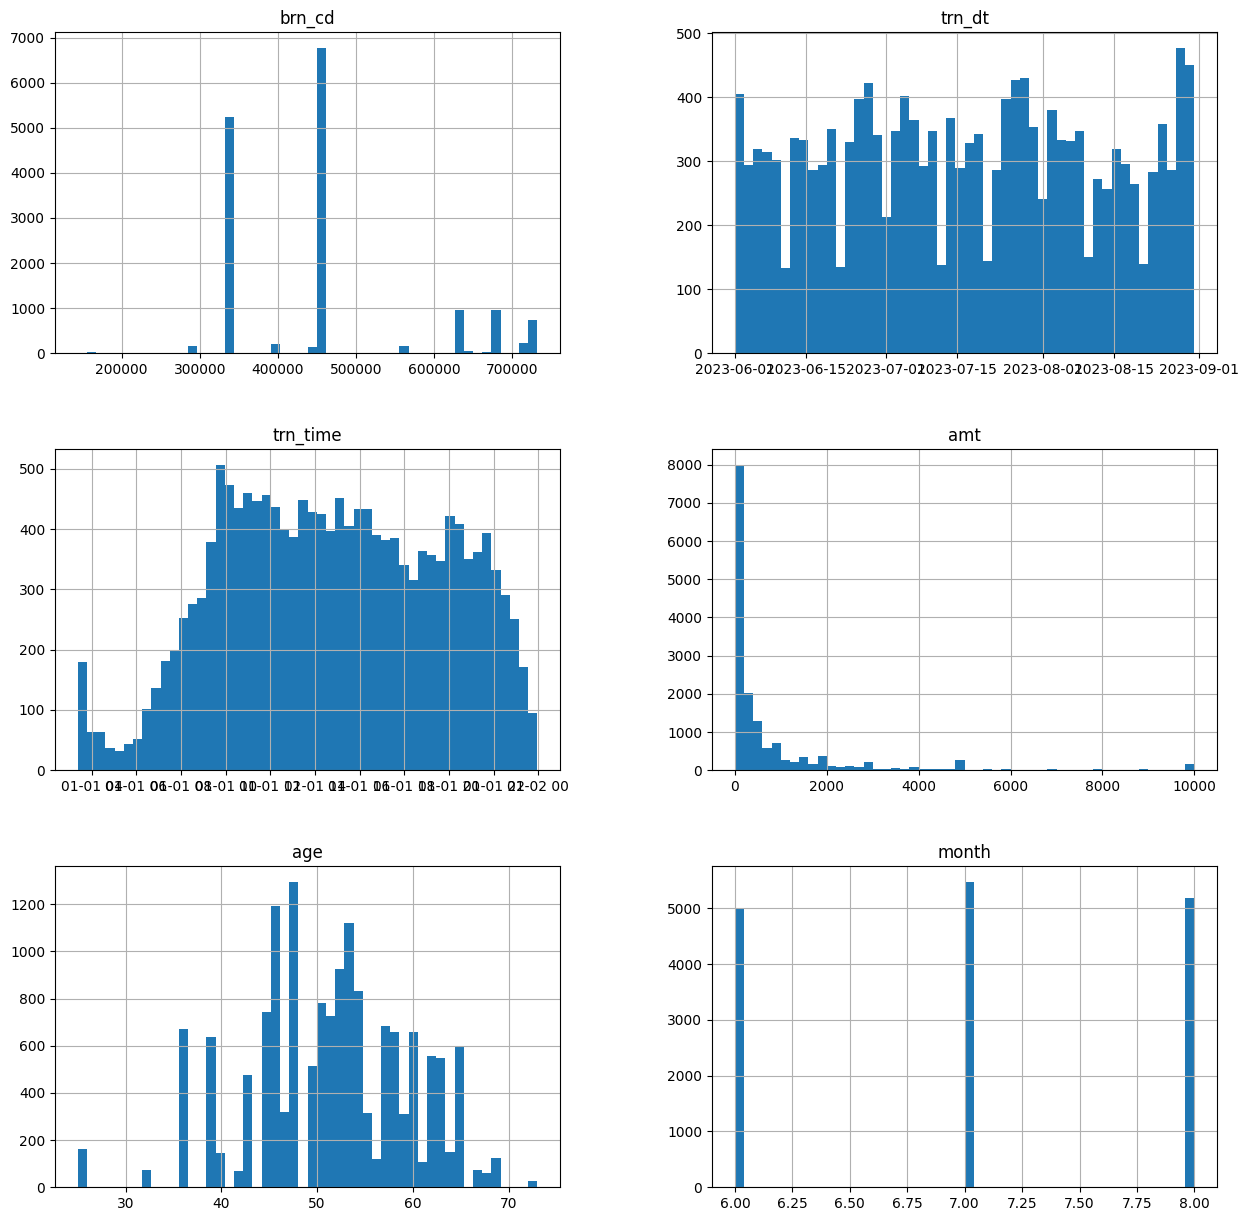

In [152]:
# Plotting the data distribution
df.hist(bins = 50,figsize = (15,15))
plt.show()

**(b) Visualise transaction volume across different time periods. Are there any patterns in spending behaviour during specific times of the day or week?**

*Transactions peak between 10 AM and 3 PM, with the busiest hours being 11 AM and 12 PM. After 3 PM, the number of transactions gradually declines, remaining steady through the evening until around 9 PM, followed by a sharp drop after 9 PM, with the least activity observed around 3 AM and 4 AM when most people are likely inactive.*

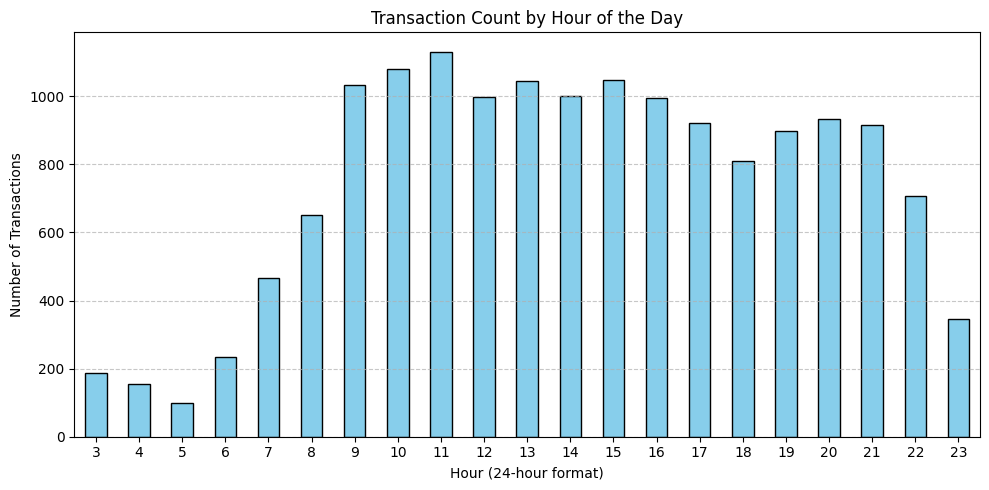

In [153]:
# Extract the hour from 'trn_time'
df['hour'] = df['trn_time'].dt.hour

# Plot transaction count by hour
plt.figure(figsize=(10, 5))
df['hour'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Transaction Count by Hour of the Day')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Transactions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

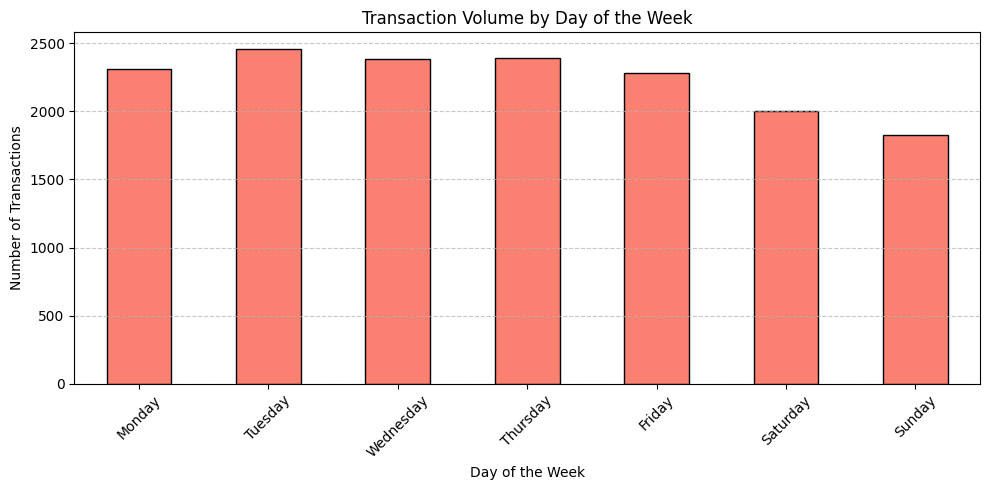

In [154]:
# Extract day of the week
df['day'] = df['trn_dt'].dt.day_name()

# Count transactions per day
day_counts = df['day'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Plot
plt.figure(figsize=(10, 5))
day_counts.plot(kind='bar', color='salmon', edgecolor='black')

plt.title('Transaction Volume by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

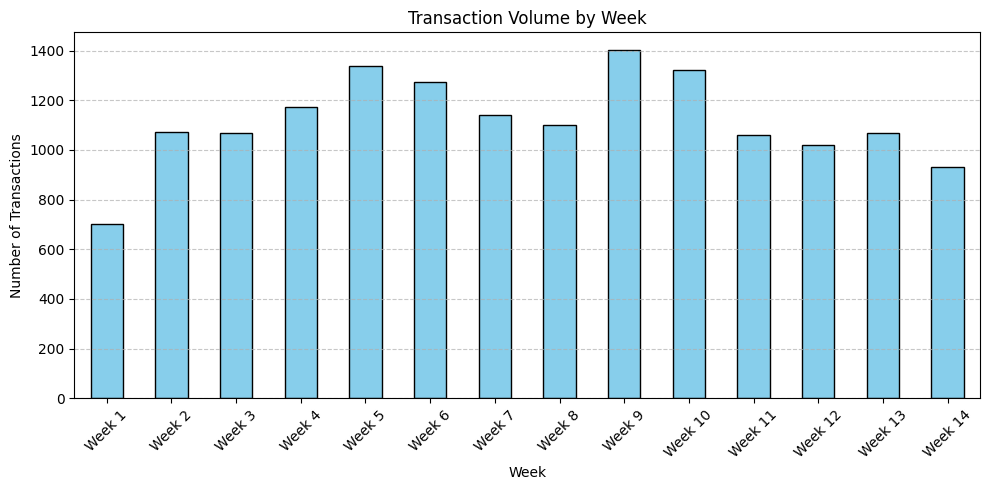

In [155]:
# Extract the week number from the transaction date
df['week'] = df['trn_dt'].dt.isocalendar().week

# Count transactions per week
week_counts = df['week'].value_counts().sort_index()  # Sort by week number

# Create week labels (Week 1, Week 2, etc.)
week_labels = ['Week ' + str(i) for i in range(1, len(week_counts) + 1)]

# Plot
plt.figure(figsize=(10, 5))
week_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Transaction Volume by Week')
plt.xlabel('Week')
plt.ylabel('Number of Transactions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=range(len(week_counts)), labels=week_labels, rotation=45)
plt.tight_layout()
plt.show()


## 3. Banking Context: Malaysia-Specific Transactions 

**(a) What aspects of the dataset reflect banking transactions unique to Malaysia?** 

*The dataset reflects Malaysia-specific banking transactions in several ways. For example, the branch code (brn_cd) follows a format typical of Malaysian banks, which use standardized numbering to identify branches. Additionally, the transaction channel (chn) field includes values like FPX (Financial Process Exchange) and MEPS (Malaysia Electronic Payment System), which are systems specific to Malaysia for processing interbank transactions and ATM/POS operations. These local channels, alongside transaction descriptions such as "FUND TRANSFER" and "PAYMENT," indicate that the dataset is aligned with the Malaysian banking framework and regulatory environment, a detail that is crucial for ensuring compliance, tailoring local banking products, and strengthening cybersecurity measures in the region.*

**(b) If you could add one more column to better represent banking transactions in Malaysia, what would it be and why?** 

*It would be useful to add a column called **Merchant Category (`mcht_ct`)** that categorizes the merchant or service provider involved in the transaction (for example, retail, utilities, entertainment, online services, groceries, etc.). This enhancement is beneficial because it allows for deeper insight into consumer spending habits and helps banks and financial institutions tailor their services, marketing strategies, and risk assessments more effectively.*

In [156]:
# SQL quries
# with sqlite3.connect('dummy dataset.db') as conn:
#     query = """
#     ALTER TABLE transactions
#     ADD mcht_ct VARCHAR(50);
#     """
#     df = pd.read_sql_query(query, conn)
#
# df.head()

In [157]:
# Python script
#df['mcht_ct'] = ''

# **Part 2: Dataset Analysis**

## 1. Customer Behaviour Analysis 

**(a) Which transaction channel is used the most, and why do you think that is?**

*The most used transaction channel in the dataset is **IB (Internet Banking)**, with 12,423 transactions. This is likely due to its convenience, allowing users to perform transactions anytime and anywhere without visiting a physical branch. In Malaysia, the push toward digital banking supported by initiatives from Bank Negara Malaysia and platforms like FPX has significantly increased the adoption of online banking services. Customers are also drawn to IB because it often offers lower fees, faster processing, and enhanced security features. This widespread usage reflects the country’s broader shift toward digital financial services and customer preference for efficient, accessible, and secure transaction methods.*

In [158]:
# Count the usage of each transaction channel
channel_counts = df['chn'].value_counts()

# Display the most used channel
chn = channel_counts.idxmax()
chn_count = channel_counts.max()

print(f"The most used transaction channel is: {chn} with {chn_count} transactions.")

The most used transaction channel is: IB with 12423 transactions.


**(b) Identify one key transaction trend or pattern in your dataset. Why is this trend important?**

*One key transaction pattern in the dataset is the movement of funds through multiple accounts without clear justification. This behavior can indicate an attempt to obscure the origin and destination of money. Rapid and repeated transfers between different accounts, particularly across branches or regions, are often associated with layering—a stage in the money laundering process designed to hide the source of illicit funds. Detecting such patterns is crucial for cybersecurity and financial institutions to prevent illegal activities and ensure regulatory compliance.*

## 2. Transaction Insights

**(a) If you were asked to forecast transaction trends for the next quarter, what factors would you consider, and what approach would you take?**

*To forecast transaction trends for the next quarter, I would consider factors like historical transaction volumes, seasonal patterns, promotional campaigns, economic conditions, and shifts in customer behavior. It's essential to assess the impact of holidays, marketing initiatives, and events, as these could drive spikes or declines in transactions. Additionally, market conditions like inflation or consumer confidence should be taken into account, as they can influence spending behavior.*

**(b) Describe the methodology you would use (e.g., statistical methods, machine learning, business intuition).** 

*The methodology would involve a combination of statistical models and machine learning techniques. Time series analysis methods like ARIMA or SARIMA would help capture trends, seasonality, and cyclical patterns in the data. Random Forests or other ensemble models could be employed to handle high-dimensional data and identify non-linear interactions, such as the impact of campaigns vs economic factors. Business intuition would also play a role, working with domain experts to interpret model outputs, adjust predictions based on qualitative insights (e.g., competitor actions), and validate predictions with real-time data to ensure accuracy.*

## 3. Technical Considerations & Data Quality

**(a) What are some potential data quality issues that could arise when collecting transaction data? How would you address them?**

*Firstly, human errors, system integration issues, or outdated data can lead to discrepancies, such as misspelled or incorrect transaction amounts. To address this, automated validation checks should be implemented during data entry to catch these errors early. Secondly, the presence of missing critical fields, often due to insufficient entry requirements, can lead to incomplete records. This can be mitigated by enforcing mandatory fields in data collection forms and flagging any incomplete entries. Lastly, overlapping entries from multiple systems can create redundancy and confusion. To prevent this, deduplication algorithms and Master Data Management (MDM) strategies should be employed to maintain a single, accurate source of truth across systems.*

In [159]:
# # Combine into full datetime
df['trn_time'] = pd.to_datetime(df['trn_time'], format='%H%M%S').dt.time
df['trn_datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['trn_dt'].date(), row['trn_time']), axis=1)

# # Now you can sort by this
df.sort_values(by='trn_datetime', inplace=True)

In [160]:
# Drop columns like month, hour, day, week
df.drop(columns=['month', 'hour', 'day', 'week'], inplace=True)

# Save the updated dataframe to a new CSV file
df.to_csv("new dummy dataset.txt", index=False)

In [162]:
# Load the TXT file
df = pd.read_csv("new dummy dataset.txt")
df.sample(5)

,trn_no,acc_no,cus_no,brn_cd,trn_type,trn_dt,trn_time,amt,trn_desc,chn,gndr,age,trn_datetime
3412,36650909942692844428,522778700730,1.834078e+09,728812,DEBIT,2023-06-22 00:00:00+00:00,12:28:31,58.03,PAYMENT,FPX,MALE,52.0,2023-06-22 12:28:31
13582,15179452279955168353,119414046114,3.481073e+09,678972,DEBIT,2023-08-20 00:00:00+00:00,14:17:36,264.00,PAYMENT,MEPS,MALE,46.0,2023-08-20 14:17:36
5474,58524442605178013510,845059346432,7.650680e+09,449836,DEBIT,2023-07-03 00:00:00+00:00,16:21:25,2000.00,PAYMENT,IB,MALE,57.0,2023-07-03 16:21:25
9133,15591934161718197262,268674498118,4.732104e+09,339201,DEBIT,2023-07-25 00:00:00+00:00,15:13:29,1000.00,FUND TRANSFER,IB,FEMALE,46.0,2023-07-25 15:13:29
12841,490239713113778526,869846809051,7.848430e+09,291393,DEBIT,2023-08-15 00:00:00+00:00,12:27:33,50.00,SALE DEBIT,POS,MALE,58.0,2023-08-15 12:27:33


In [163]:
# Connect to SQLite database (creates a new one in memory)
conn = sqlite3.connect(':memory:')

# Load DataFrame into a SQLite table
df.to_sql('transactions', conn, index=False, if_exists='replace')

print("CSV data has been successfully written to the database!")


CSV data has been successfully written to the database!


In [164]:
# ALTER TABLE transactions
# DROP COLUMN month,
# DROP COLUMN hour,
# DROP COLUMN day,
# DROP COLUMN week;

**(b) Write one SQL query to gain insight from your dataset (e.g., finding the most active customers, detecting large transactions). Explain what your query does and why it is useful.**

*This query identifies the top 5 customers with the most transaction, helping businesses focus on high-value customers for targeted strategies and promotions.*

In [165]:
query = """
SELECT cus_no, COUNT(*) AS transaction_count
FROM transactions 
GROUP BY cus_no 
ORDER BY transaction_count DESC 
LIMIT 5;
"""

df = pd.read_sql_query(query, conn)
df.head()

,cus_no,transaction_count
0,4.732104e+09,610
1,7.010924e+09,481
2,5.591584e+09,462
3,8.377870e+09,433
4,6.998723e+09,384


*This query identifies the top 5 customers based on their total transaction amounts, enabling businesses to pinpoint high-value customers and detect potential suspicious patterns or irregularities in spending behavior.*

In [166]:
query = """
SELECT cus_no, SUM(amt) AS total_amount
FROM transactions
GROUP BY cus_no
ORDER BY total_amount DESC
LIMIT 5;
"""
df = pd.read_sql_query(query, conn)
df.head()

,cus_no,total_amount
0,2.631584e+09,778841.06
1,4.071105e+09,500933.65
2,4.407145e+09,385836.43
3,8.438417e+09,350975.10
4,8.900772e+09,329276.27


## 4. SQL Challenge

**(a) Write an SQL query to find all accounts that have at least three consecutive withdrawal transactions exceeding RM 5,000, ordered by transaction date.** 

*This code queries to find customers with three consecutive withdrawals over 5000, ordered by transaction date. It uses a CTE with `ROW_NUMBER()` to identify consecutive transactions. This query is useful for detecting customers who make consecutive large withdrawals, which could indicate suspicious activity, such as money laundering or financial distress.*

In [167]:
query = """
WITH Withdrawals AS (
    SELECT
        acc_no,
        trn_dt,
        ROW_NUMBER() OVER (PARTITION BY acc_no ORDER BY trn_dt) AS rn
    FROM transactions
    WHERE trn_type = 'DEBIT' AND amt > 5000
)
SELECT
    a.acc_no,
    a.trn_dt AS date1,
    b.trn_dt AS date2,
    c.trn_dt AS date3
FROM Withdrawals a
JOIN Withdrawals b ON a.acc_no = b.acc_no AND b.rn = a.rn + 1
JOIN Withdrawals c ON a.acc_no = c.acc_no AND c.rn = b.rn + 1
ORDER BY a.acc_no, a.trn_dt;
"""

df = pd.read_sql_query(query, conn)
df.head()


,acc_no,date1,date2,date3
0,116582005497,2023-08-15 00:00:00+00:00,2023-08-20 00:00:00+00:00,2023-08-24 00:00:00+00:00
1,116582005497,2023-08-20 00:00:00+00:00,2023-08-24 00:00:00+00:00,2023-08-28 00:00:00+00:00
2,116582005497,2023-08-24 00:00:00+00:00,2023-08-28 00:00:00+00:00,2023-08-30 00:00:00+00:00
3,178018689070,2023-06-24 00:00:00+00:00,2023-06-25 00:00:00+00:00,2023-07-24 00:00:00+00:00
4,178018689070,2023-06-25 00:00:00+00:00,2023-07-24 00:00:00+00:00,2023-07-24 00:00:00+00:00


**(b) Modify your query to detect four or more consecutive withdrawals instead of three.**

*This code retrieves transactions where customers made 4 or more consecutive large debit withdrawals (over 5000). It uses window functions(ROW_NUMBER) to group consecutive transactions by account, then filters groups with 4 or more withdrawals. The results, including account number and transaction dates.*

In [168]:
query = """
WITH Withdrawals AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY acc_no ORDER BY trn_dt) 
        - ROW_NUMBER() OVER (PARTITION BY acc_no, trn_type ORDER BY trn_dt) AS grp
    FROM transactions
    WHERE trn_type = 'DEBIT' AND amt > 5000
),
GroupedWithdrawals AS (
    SELECT 
        acc_no, 
        grp, 
        COUNT(*) AS withdrawal_count,
        MIN(trn_dt) AS start_date,
        MAX(trn_dt) AS end_date
    FROM Withdrawals
    GROUP BY acc_no, grp
    HAVING COUNT(*) >= 4
)
SELECT * FROM GroupedWithdrawals
ORDER BY acc_no, start_date;
"""

df = pd.read_sql_query(query, conn)
df.head()

,acc_no,grp,withdrawal_count,start_date,end_date
0,116582005497,0,5,2023-08-15 00:00:00+00:00,2023-08-30 00:00:00+00:00
1,178018689070,0,5,2023-06-24 00:00:00+00:00,2023-08-16 00:00:00+00:00
2,183264629830,0,8,2023-06-01 00:00:00+00:00,2023-08-23 00:00:00+00:00
3,268624875891,0,5,2023-07-06 00:00:00+00:00,2023-08-29 00:00:00+00:00
4,268674498118,0,6,2023-06-10 00:00:00+00:00,2023-08-13 00:00:00+00:00
